# Übung 3 - Kraftwerkseinsatzplanung

Folgendes Code-Gerüst kann zur Lösung der Übung 3 verwendet werden.

Shadow Prices for each hour (Optimal prices under competition):
Hour 0: 160.98 €/MWh
Hour 1: 155.00 €/MWh
Hour 2: 155.00 €/MWh
Hour 3: 155.00 €/MWh
Hour 4: 155.00 €/MWh
Hour 5: 155.00 €/MWh
Hour 6: 160.98 €/MWh
Hour 7: 160.98 €/MWh
Hour 8: 160.98 €/MWh
Hour 9: 160.98 €/MWh
Hour 10: 160.98 €/MWh
Hour 11: 160.98 €/MWh
Hour 12: 160.98 €/MWh
Hour 13: 160.98 €/MWh
Hour 14: 160.98 €/MWh
Hour 15: 160.98 €/MWh
Hour 16: 160.98 €/MWh
Hour 17: 160.98 €/MWh
Hour 18: 160.98 €/MWh
Hour 19: 160.98 €/MWh
Hour 20: 160.98 €/MWh
Hour 21: 160.98 €/MWh
Hour 22: 160.98 €/MWh
Hour 23: 160.98 €/MWh


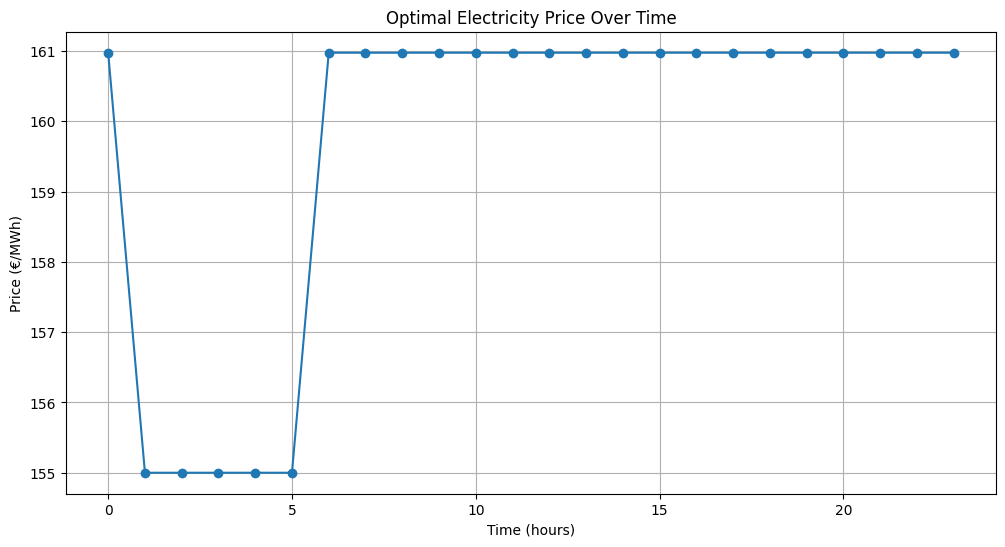

Optimized Cost of Electricity:  3261051
Resulting Cost of GHG Emissions:  1034701


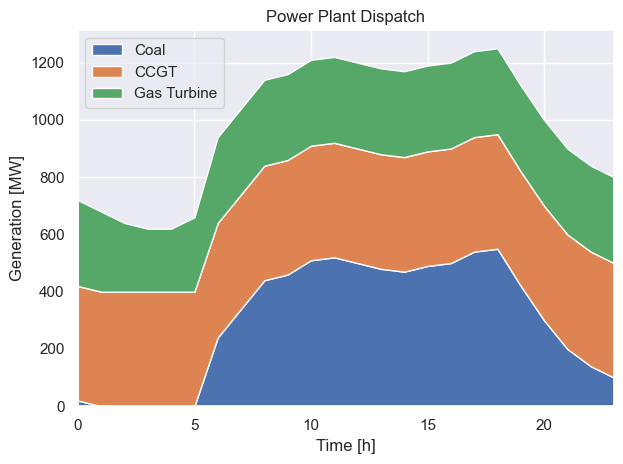

In [2]:
from pyomo.environ import *  # noqa: F403
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


T = 24
timesteps = np.arange(T)

c_CO2 = 80 # EUR/tCO2

# Calculate marginal costs of thermal power plants
# Note: does not correspond to all values in the description!
thermalPlant = ['Coal', 'CCGT', 'Gas Turbine']
power = {'Coal': 600,
         'CCGT': 400,
         'Gas Turbine': 300} # MW
efficiency = {'Coal': 0.41,
         'CCGT': 0.58,
         'Gas Turbine': 0.4} 
fuel_price = {'Coal': 10,
         'CCGT': 30,
         'Gas Turbine': 30} # EUR/MWhprim
emission_factor = {'Coal': 0.35,
         'CCGT': 0.2,
         'Gas Turbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Load data
df = pd.read_excel('Last_PV_Wind.xlsx')
load = df['Last Winter [MW]'] # enter group number Summer/Winter here
Wind = df['Wind 300 MW']
PV = df['PV 200 MW Winter']


# Create Pyomo model
model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)
model.dual = Suffix(direction=Suffix.IMPORT)  # Enable dual information

# Specify objective function!

model.obj = Objective(
    expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps) + 
           sum(model.x[n,t] * emissions[n] * c_CO2 for n in thermalPlant for t in timesteps),
    sense = minimize
)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]

model.power_con = Constraint(thermalPlant, timesteps, rule = power_constraint_rule)
model.load_con = Constraint(timesteps, rule = load_constraint_rule)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

# model.display()

# Get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value


# Calculate total generation and shadow prices for each timestep
total_generation = PowerThermal.sum(axis=1)
shadow_prices = {t: model.dual[model.load_con[t]] for t in timesteps}


# Display the results
print("Shadow Prices for each hour (Optimal prices under competition):")
for t in timesteps:
    print(f"Hour {t}: {shadow_prices[t]:.2f} €/MWh")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(timesteps, [shadow_prices[t] for t in timesteps], marker='o', linestyle='-')
plt.title('Optimal Electricity Price Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Price (€/MWh)')
plt.grid(True)
plt.show()

# Plot

sns.set()

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             PowerThermal.to_numpy(dtype = float).transpose(), 
             labels=thermalPlant)
ax.set_title('Power Plant Dispatch')
ax.legend(loc='upper left')
ax.set_ylabel('Generation [MW]')
ax.set_xlabel('Time [h]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

optimized_cost = model.obj()
resulting_emissions = sum(model.x[n,t].value * emissions[n] * c_CO2 for n in thermalPlant for t in timesteps)

print("Optimized Cost of Electricity: ", round(optimized_cost))
print("Resulting Cost of GHG Emissions: ", round(resulting_emissions))


The shadow values resulting from the model can be interpreted as follows.

Two values are prevalent:
- 155.00: between 1 AM and 5 AM
- 160.97: at midnight and from 7 AM until 11 PM

This reflects the fact that an increase in load comes with a higher marginal cost during hours associated with a value of 160.97 as opposed to those corresponding to 155.00.

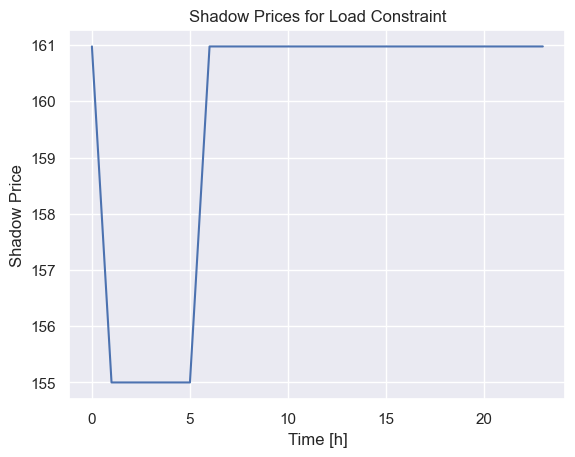

In [3]:

shadow_prices = {t: model.dual[model.load_con[t]] for t in timesteps}
shadow_prices_values = list(shadow_prices.values())
plt.plot(timesteps, shadow_prices_values)
plt.title('Shadow Prices for Load Constraint')
plt.xlabel('Time [h]')
plt.ylabel('Shadow Price')
plt.show()


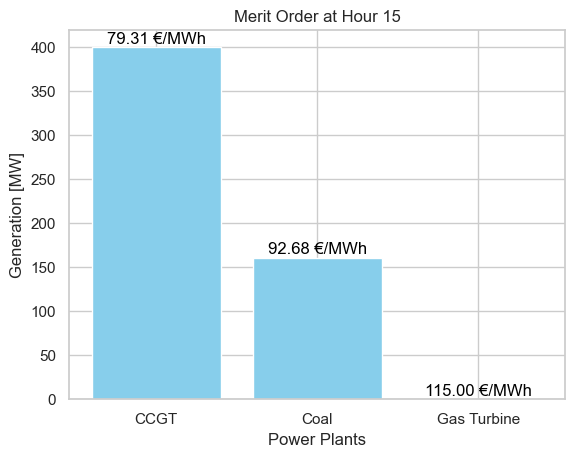

In [26]:
# Plotting merit order graph for hour 15
hour = 0
sorted_plants = sorted(thermalPlant, key=lambda n: MC[n])
sorted_generation = [PowerThermal.loc[hour, plant] for plant in sorted_plants]
sorted_prices = [MC[plant] for plant in sorted_plants]

fig, ax2 = plt.subplots()
ax2.bar(sorted_plants, sorted_generation, color='skyblue')
ax2.set_title('Merit Order at Hour 15')
ax2.set_xlabel('Power Plants')
ax2.set_ylabel('Generation [MW]')
for i, v in enumerate(sorted_generation):
    ax2.text(i, v + 5, f"{sorted_prices[i]:.2f} €/MWh", ha='center', color='black')
plt.show()

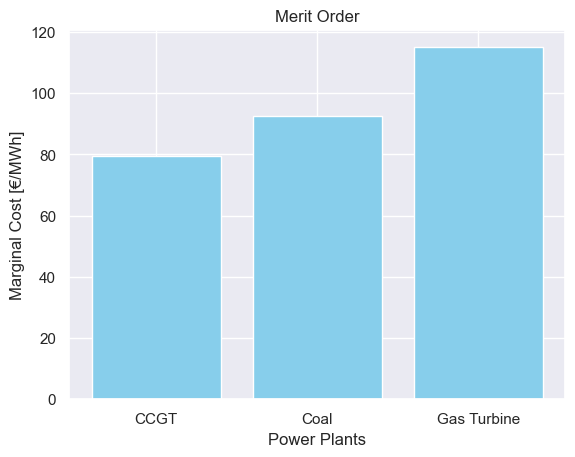

In [5]:
# Plotting merit order graph for hour 5
hour = 22
sorted_plants = sorted(thermalPlant, key=lambda n: MC[n])
sorted_generation = [PowerThermal.loc[hour, plant] for plant in sorted_plants]
sorted_prices = [MC[plant] for plant in sorted_plants]

plt.bar(sorted_plants, sorted_prices, color='skyblue')
for i, v in enumerate(sorted_generation):
    ax2.text(i, v + 5, f"{sorted_prices[i]:.2f} €/MWh", ha='center', color='black')
plt.title('Merit Order')
plt.xlabel('Power Plants')
plt.ylabel('Marginal Cost [€/MWh]')
plt.show()

# Added Renewables

unknown
Shadow Prices for each hour (Optimal prices under competition):
Hour 0: 92.68 €/MWh
Hour 1: 92.68 €/MWh
Hour 2: 92.68 €/MWh
Hour 3: 92.68 €/MWh
Hour 4: 92.68 €/MWh
Hour 5: 92.68 €/MWh
Hour 6: 92.68 €/MWh
Hour 7: 92.68 €/MWh
Hour 8: 92.68 €/MWh
Hour 9: 92.68 €/MWh
Hour 10: 92.68 €/MWh
Hour 11: 92.68 €/MWh
Hour 12: 115.00 €/MWh
Hour 13: 115.00 €/MWh
Hour 14: 115.00 €/MWh
Hour 15: 115.00 €/MWh
Hour 16: 115.00 €/MWh
Hour 17: 115.00 €/MWh
Hour 18: 115.00 €/MWh
Hour 19: 115.00 €/MWh
Hour 20: 92.68 €/MWh
Hour 21: 92.68 €/MWh
Hour 22: 92.68 €/MWh
Hour 23: 92.68 €/MWh


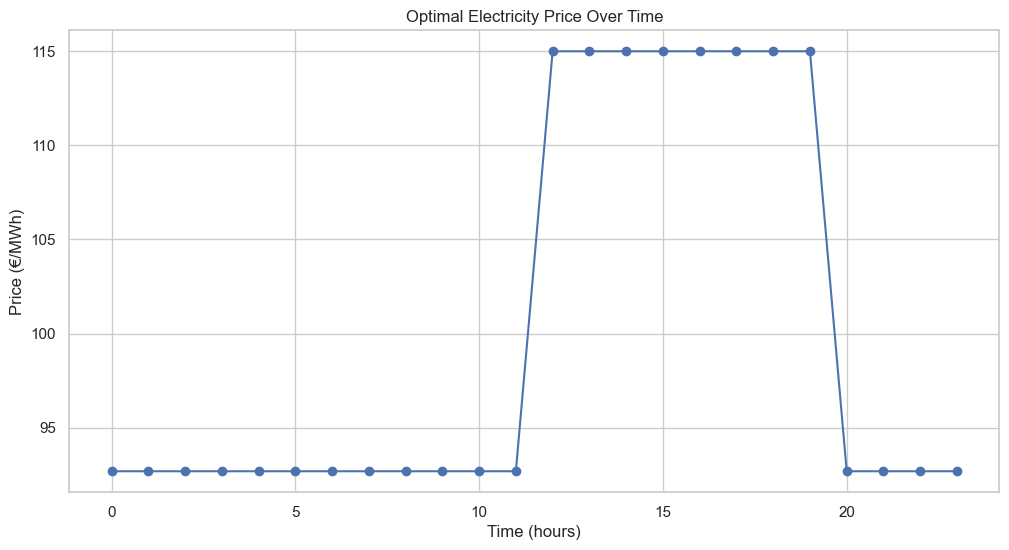

Optimized Cost of Electricity:  1800779
Resulting GHG Emissions:  12474


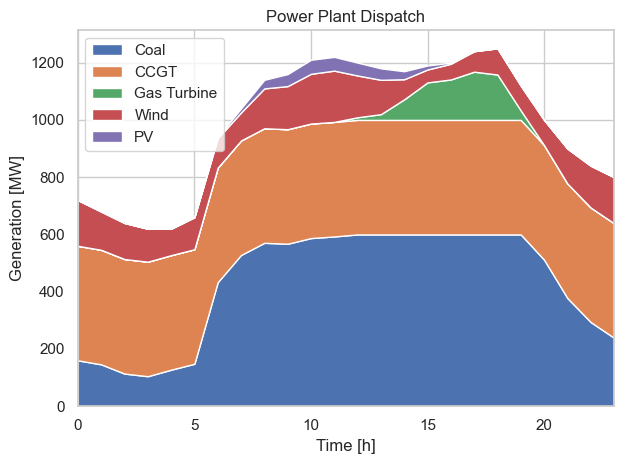

In [27]:

   
# Create Pyomo model
model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)
model.dual = Suffix(direction=Suffix.IMPORT)  # Enable dual information

print(model)

# Specify objective function!

model.obj = Objective(
    expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps) + 
           sum(model.x[n,t] * emissions[n] * c_CO2 for n in thermalPlant for t in timesteps),
    sense = minimize
)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t] - Wind[t] - PV[t]


model.power_con = Constraint(thermalPlant, timesteps, rule = power_constraint_rule)
model.load_con = Constraint(timesteps, rule = load_constraint_rule)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)



# model.display()

# Get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value
    PowerThermal.loc[t, 'Wind'] = Wind[t]
    PowerThermal.loc[t, 'PV'] = PV[t]



# Calculate total generation and shadow prices for each timestep
total_generation = PowerThermal.sum(axis=1)
shadow_prices = {t: model.dual[model.load_con[t]] for t in timesteps}


# Display the results
print("Shadow Prices for each hour (Optimal prices under competition):")
for t in timesteps:
    print(f"Hour {t}: {shadow_prices[t]:.2f} €/MWh")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(timesteps, [shadow_prices[t] for t in timesteps], marker='o', linestyle='-')
plt.title('Optimal Electricity Price Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Price (€/MWh)')
plt.grid(True)
plt.show()

# Plot

sns.set_theme(style='whitegrid')

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             PowerThermal.to_numpy(dtype = float).transpose(), 
             labels=thermalPlant + ['Wind', 'PV'])
ax.set_title('Power Plant Dispatch')
ax.legend(loc='upper left')
ax.set_ylabel('Generation [MW]')
ax.set_xlabel('Time [h]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

optimized_cost = model.obj()
resulting_emissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)

print("Optimized Cost of Electricity: ", round(optimized_cost))
print("Resulting GHG Emissions: ", round(resulting_emissions))


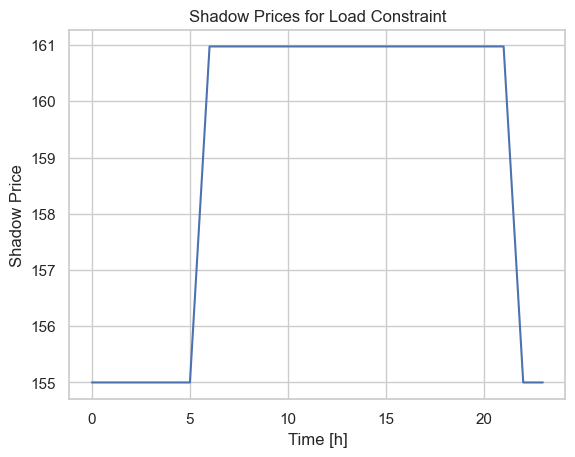

In [7]:
shadow_prices = {t: model.dual[model.load_con[t]] for t in timesteps}
shadow_prices_values = list(shadow_prices.values())
plt.plot(timesteps, shadow_prices_values)
plt.title('Shadow Prices for Load Constraint')
plt.xlabel('Time [h]')
plt.ylabel('Shadow Price')
plt.show()


# Added Storage

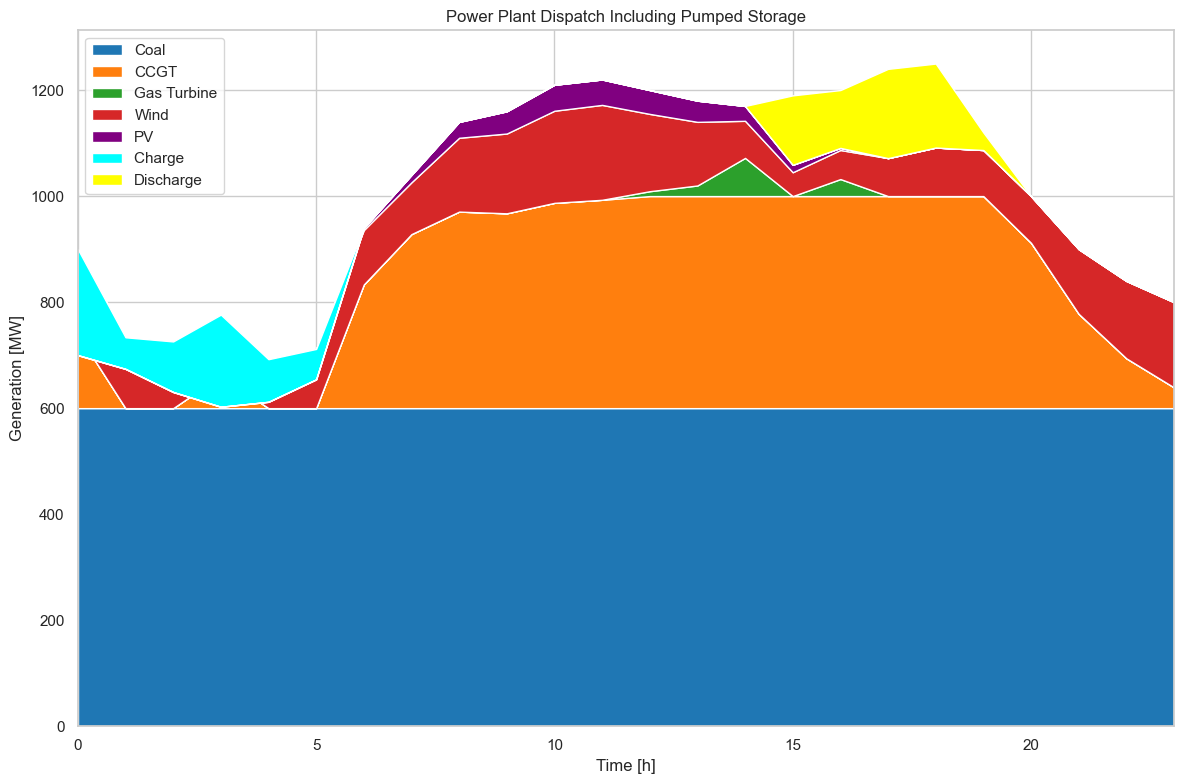

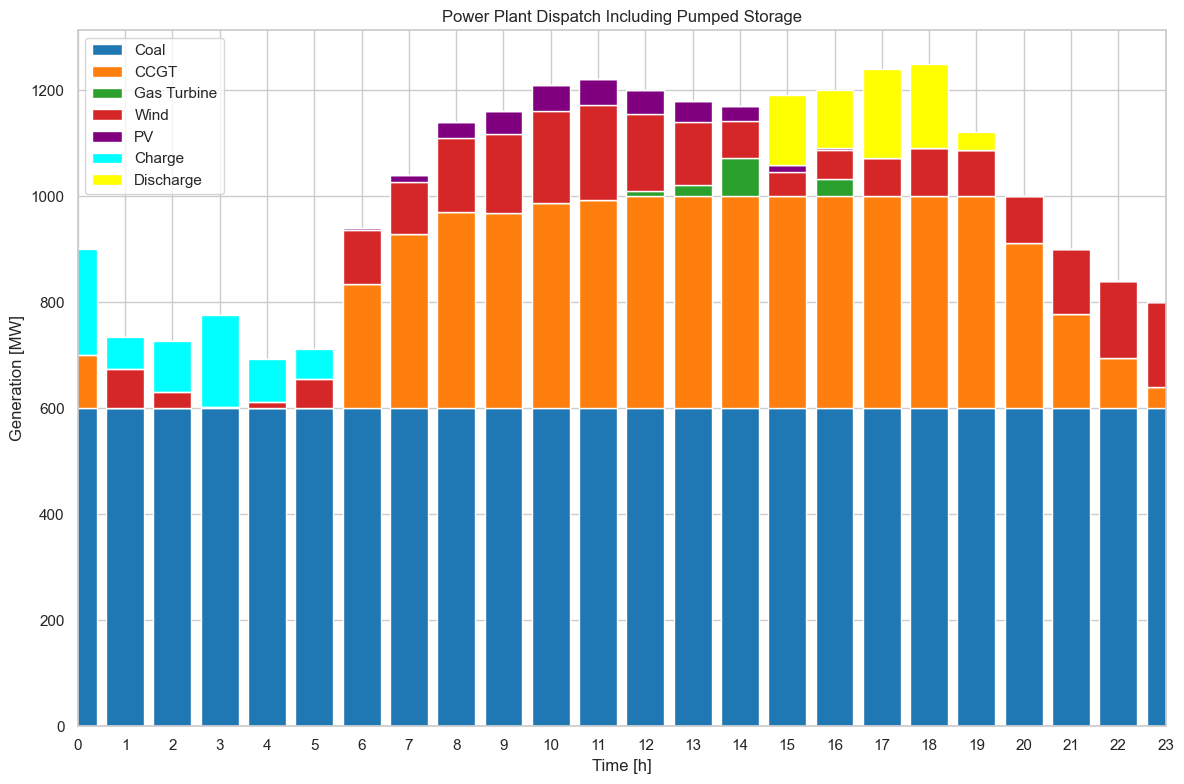

Resulting GHG Emissions:  14464


In [28]:
# Calculate marginal costs of thermal power plants
# Note: does not correspond to all values in the description!
thermalPlant = ['Coal', 'CCGT', 'Gas Turbine']
power = {
         'Coal': 600,
         'CCGT': 400,
         'Gas Turbine': 300} # MW
efficiency = {
         'Coal': 0.41,
         'CCGT': 0.58,
         'Gas Turbine': 0.4} 
fuel_price = {
         'Coal': 10,
         'CCGT': 30,
         'Gas Turbine': 30} # EUR/MWhprim
emission_factor = {
         'Coal': 0.35,
         'CCGT': 0.2,
         'Gas Turbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]

# Create Pyomo model
model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within=NonNegativeReals)
model.charge = Var(timesteps, within=NonNegativeReals)
model.discharge = Var(timesteps, within=NonNegativeReals)
model.storage_level = Var(timesteps, bounds=(0, 600))  # 600 MW max storage capacity

# Specify objective function!
model.obj = Objective(
    expr=sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps) + 
         sum(model.x[n,t] * emissions[n] * c_CO2 for n in thermalPlant for t in timesteps),
    sense=minimize
)

# Constraints
def power_constraint_rule(model, n, t):
    return model.x[n,t] <= power[n]

def load_constraint_rule(model, t):
    return (sum(model.x[n,t] for n in thermalPlant) + model.discharge[t] - 
            model.charge[t] * 0.9 == load[t] - Wind[t] - PV[t])

def no_simultaneous_charge_discharge_rule(model, t):
    return model.charge[t] * model.discharge[t] == 0

def max200c(model, t):
    return model.charge[t] <= 200

def max200d(model, t):
    return model.discharge[t] <= 200

def storage_balance_rule(model, t):
    if t == timesteps[0]:
        return model.storage_level[t] == model.charge[t] * 0.9 - model.discharge[t]
    else:
        return model.storage_level[t] == model.storage_level[t-1] + model.charge[t] * 0.9 - model.discharge[t]

model.power_con = Constraint(thermalPlant, timesteps, rule=power_constraint_rule)
model.load_con = Constraint(timesteps, rule=load_constraint_rule)
model.no_simultaneous_charge_discharge = Constraint(timesteps, rule=no_simultaneous_charge_discharge_rule)
model.storage_balance = Constraint(timesteps, rule=storage_balance_rule)
model.max200c = Constraint(timesteps, rule=max200c)
model.max200d = Constraint(timesteps, rule=max200d)

# Enable dual variables
model.dual = Suffix(direction=Suffix.IMPORT)

# Solving the model
opt = SolverFactory('gurobi')
opt.options['NonConvex'] = 2
opt.options['QCPDual'] = 1
opt_success = opt.solve(model)


# Post-processing
PowerThermal = pd.DataFrame(index=timesteps, columns=thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value
    PowerThermal.loc[t, 'Wind'] = Wind[t]
    PowerThermal.loc[t, 'PV'] = PV[t]
    PowerThermal.loc[t, 'Charge'] = model.charge[t].value
    PowerThermal.loc[t, 'Discharge'] = model.discharge[t].value

PowerThermal = PowerThermal.astype(float)

# Adjust the stackplot to include Charge and Discharge
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(timesteps, 
             PowerThermal['Coal'], PowerThermal['CCGT'], PowerThermal['Gas Turbine'], 
             PowerThermal['Wind'], PowerThermal['PV'], -PowerThermal['Charge'],
             PowerThermal['Discharge'],
             labels=['Coal', 'CCGT', 'Gas Turbine', 'Wind', 'PV', 'Charge ', 'Discharge'],
             colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'purple', 'cyan', 'yellow'])
ax.set_title('Power Plant Dispatch Including Pumped Storage')
ax.legend(loc='upper left')
ax.set_ylabel('Generation [MW]')
ax.set_xlabel('Time [h]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()



fig, ax = plt.subplots(figsize=(12, 8))

# Assuming timesteps is a list or array of time points
bar_width = 0.8
timesteps_indices = np.arange(len(timesteps))

# Stacking data
bar1 = ax.bar(timesteps_indices, PowerThermal['Coal'], bar_width, label='Coal', color='tab:blue')
bar2 = ax.bar(timesteps_indices, PowerThermal['CCGT'], bar_width, bottom=PowerThermal['Coal'], label='CCGT', color='tab:orange')
bar3 = ax.bar(timesteps_indices, PowerThermal['Gas Turbine'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'], label='Gas Turbine', color='tab:green')
bar4 = ax.bar(timesteps_indices, PowerThermal['Wind'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'] + PowerThermal['Gas Turbine'], label='Wind', color='tab:red')
bar5 = ax.bar(timesteps_indices, PowerThermal['PV'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'] + PowerThermal['Gas Turbine'] + PowerThermal['Wind'], label='PV', color='purple')
bar6 = ax.bar(timesteps_indices, -PowerThermal['Charge'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'] + PowerThermal['Gas Turbine'] + PowerThermal['Wind'] + PowerThermal['PV'], label='Charge', color='cyan')
bar7 = ax.bar(timesteps_indices, PowerThermal['Discharge'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'] + PowerThermal['Gas Turbine'] + PowerThermal['Wind'] + PowerThermal['PV'] - PowerThermal['Charge'], label='Discharge', color='yellow')

ax.set_title('Power Plant Dispatch Including Pumped Storage')
ax.legend(loc='upper left')
ax.set_ylabel('Generation [MW]')
ax.set_xlabel('Time [h]')
ax.set_xlim(xmin=timesteps_indices[0], xmax=timesteps_indices[-1])
ax.set_xticks(timesteps_indices)
ax.set_xticklabels(timesteps)

fig.tight_layout()
plt.show()

optimized_cost = model.obj()
resulting_emissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)

print("Resulting GHG Emissions: ", round(resulting_emissions))




In [9]:
# Extract and print shadow prices
shadow_prices = {}
for t in timesteps:
    shadow_prices[t] = {}
    if (model.load_con[t] in model.dual):
        shadow_prices[t]['load_constraint'] = model.dual[model.load_con[t]]
    if (model.max200c[t] in model.dual):
        shadow_prices[t]['charge_constraint'] = model.dual[model.max200c[t]]
    if (model.max200d[t] in model.dual):
        shadow_prices[t]['discharge_constraint'] = model.dual[model.max200d[t]]
    if (model.storage_balance[t] in model.dual):
        shadow_prices[t]['storage_balance'] = model.dual[model.storage_balance[t]]

# Display shadow prices
for t in timesteps:
    print(f"Time {t}: {shadow_prices[t]}")

Time 0: {}
Time 1: {}
Time 2: {}
Time 3: {}
Time 4: {}
Time 5: {}
Time 6: {}
Time 7: {}
Time 8: {}
Time 9: {}
Time 10: {}
Time 11: {}
Time 12: {}
Time 13: {}
Time 14: {}
Time 15: {}
Time 16: {}
Time 17: {}
Time 18: {}
Time 19: {}
Time 20: {}
Time 21: {}
Time 22: {}
Time 23: {}


# Changing Objective Function (With Renewables)

unknown


Shadow Prices for each hour (Optimal prices under competition):
Hour 0: 0.50 €/MWh
Hour 1: 0.50 €/MWh
Hour 2: 0.50 €/MWh
Hour 3: 0.50 €/MWh
Hour 4: 0.50 €/MWh
Hour 5: 0.50 €/MWh
Hour 6: 0.85 €/MWh
Hour 7: 0.85 €/MWh
Hour 8: 0.85 €/MWh
Hour 9: 0.85 €/MWh
Hour 10: 0.85 €/MWh
Hour 11: 0.85 €/MWh
Hour 12: 0.85 €/MWh
Hour 13: 0.85 €/MWh
Hour 14: 0.85 €/MWh
Hour 15: 0.85 €/MWh
Hour 16: 0.85 €/MWh
Hour 17: 0.85 €/MWh
Hour 18: 0.85 €/MWh
Hour 19: 0.85 €/MWh
Hour 20: 0.85 €/MWh
Hour 21: 0.85 €/MWh
Hour 22: 0.50 €/MWh
Hour 23: 0.50 €/MWh


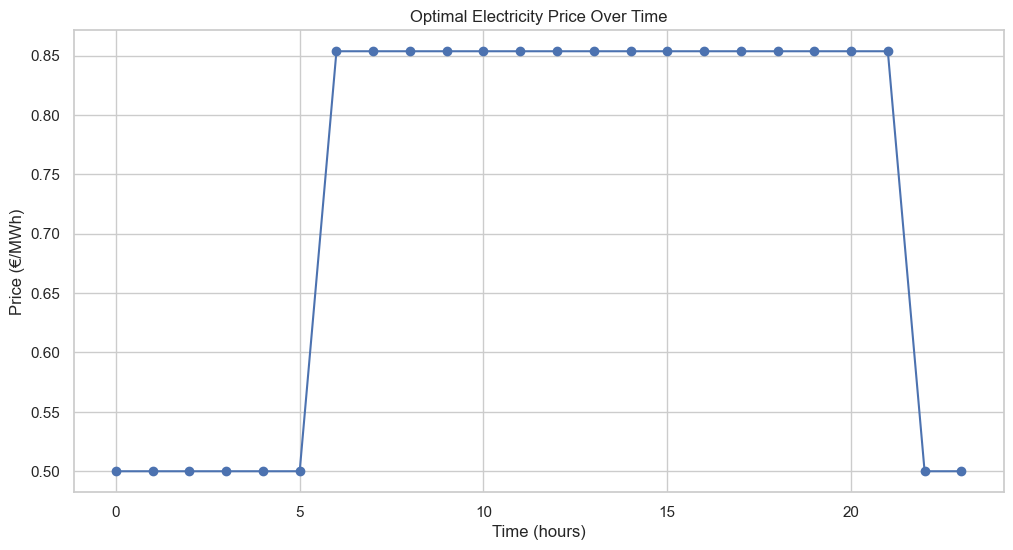

Resulting GHG Emissions:  10563


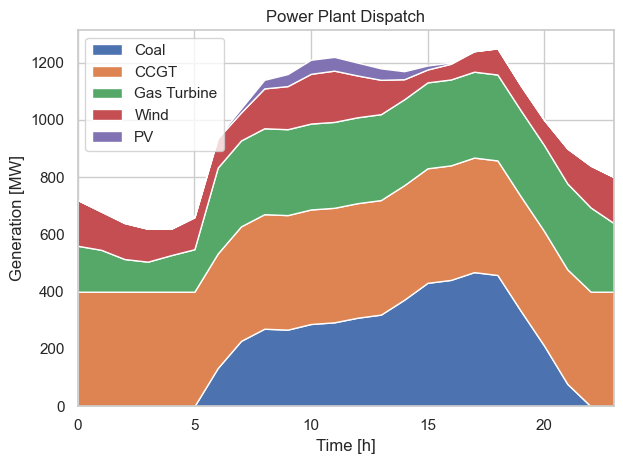

In [31]:

# Create Pyomo model
model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)
model.dual = Suffix(direction=Suffix.IMPORT)  # Enable dual information

print(model)

# Specify objective function!

model.obj = Objective(
    expr = sum(model.x[n,t] * emissions[n] for n in thermalPlant for t in timesteps),
    sense = minimize
)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t] - Wind[t] - PV[t]


model.power_con = Constraint(thermalPlant, timesteps, rule = power_constraint_rule)
model.load_con = Constraint(timesteps, rule = load_constraint_rule)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)



# model.display()

# Get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value
    PowerThermal.loc[t, 'Wind'] = Wind[t]
    PowerThermal.loc[t, 'PV'] = PV[t]



# Calculate total generation and shadow prices for each timestep
total_generation = PowerThermal.sum(axis=1)
shadow_prices = {t: model.dual[model.load_con[t]] for t in timesteps}


# Display the results
print("Shadow Prices for each hour (Optimal prices under competition):")
for t in timesteps:
    print(f"Hour {t}: {shadow_prices[t]:.2f} €/MWh")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(timesteps, [shadow_prices[t] for t in timesteps], marker='o', linestyle='-')
plt.title('Optimal Electricity Price Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Price (€/MWh)')
plt.grid(True)
plt.show()

# Plot

sns.set_theme(style='whitegrid')

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             PowerThermal.to_numpy(dtype = float).transpose(), 
             labels=thermalPlant + ['Wind', 'PV'])
ax.set_title('Power Plant Dispatch')
ax.legend(loc='upper left')
ax.set_ylabel('Generation [MW]')
ax.set_xlabel('Time [h]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

optimized_cost = model.obj()
resulting_emissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)

print("Resulting GHG Emissions: ", round(resulting_emissions))


# Changing Objective function (With Storage)

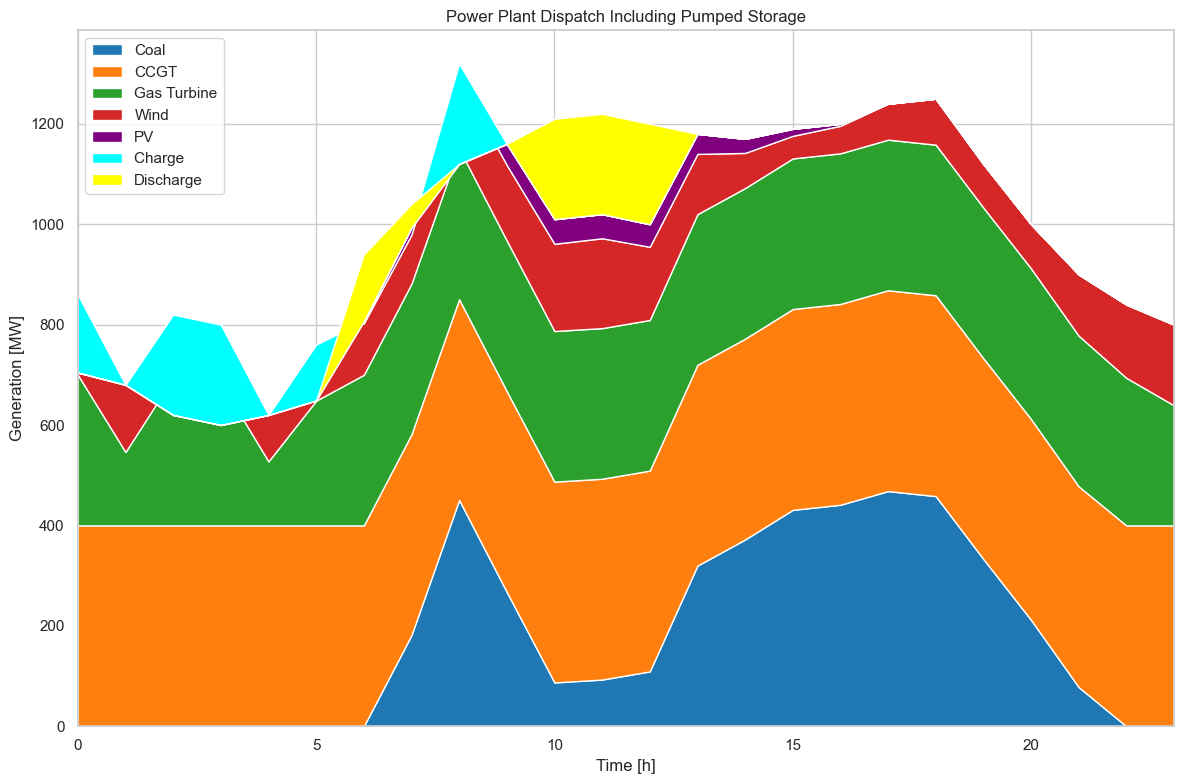

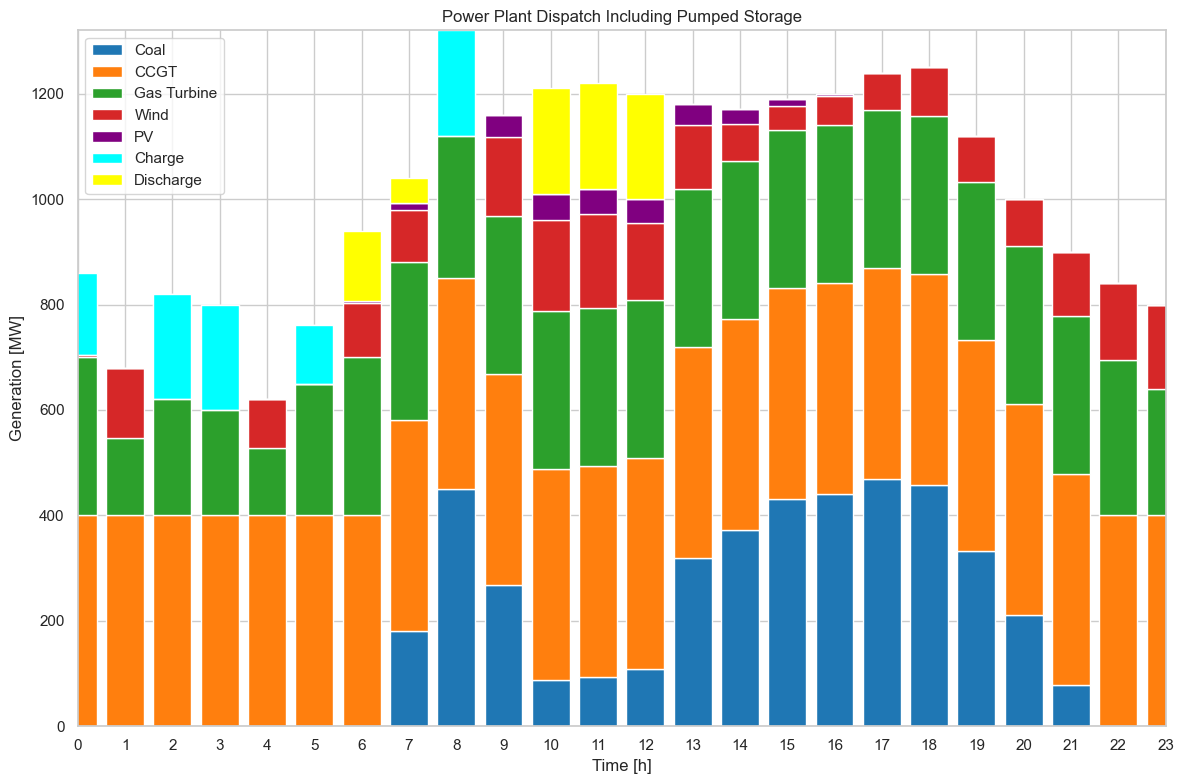

Resulting GHG Emissions:  10351


In [29]:
# Calculate marginal costs of thermal power plants
# Note: does not correspond to all values in the description!
thermalPlant = ['Coal', 'CCGT', 'Gas Turbine']
power = {
         'Coal': 600,
         'CCGT': 400,
         'Gas Turbine': 300} # MW
efficiency = {
         'Coal': 0.41,
         'CCGT': 0.58,
         'Gas Turbine': 0.4} 
fuel_price = {
         'Coal': 10,
         'CCGT': 30,
         'Gas Turbine': 30} # EUR/MWhprim
emission_factor = {
         'Coal': 0.35,
         'CCGT': 0.2,
         'Gas Turbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]

# Create Pyomo model
model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within=NonNegativeReals)
model.charge = Var(timesteps, within=NonNegativeReals)
model.discharge = Var(timesteps, within=NonNegativeReals)
model.storage_level = Var(timesteps, bounds=(0, 600))  # 600 MW max storage capacity

# Specify objective function!
model.obj = Objective(
    expr= sum(model.x[n,t] * emissions[n] for n in thermalPlant for t in timesteps),
    sense=minimize
)

# Constraints
def power_constraint_rule(model, n, t):
    return model.x[n,t] <= power[n]

def load_constraint_rule(model, t):
    return (sum(model.x[n,t] for n in thermalPlant) + model.discharge[t] - 
            model.charge[t] * 0.9 == load[t] - Wind[t] - PV[t])

def no_simultaneous_charge_discharge_rule(model, t):
    return model.charge[t] * model.discharge[t] == 0

def max200c(model, t):
    return model.charge[t] <= 200

def max200d(model, t):
    return model.discharge[t] <= 200

def storage_balance_rule(model, t):
    if t == timesteps[0]:
        return model.storage_level[t] == model.charge[t] * 0.9 - model.discharge[t]
    else:
        return model.storage_level[t] == model.storage_level[t-1] + model.charge[t] * 0.9 - model.discharge[t]

model.power_con = Constraint(thermalPlant, timesteps, rule=power_constraint_rule)
model.load_con = Constraint(timesteps, rule=load_constraint_rule)
model.no_simultaneous_charge_discharge = Constraint(timesteps, rule=no_simultaneous_charge_discharge_rule)
model.storage_balance = Constraint(timesteps, rule=storage_balance_rule)
model.max200c = Constraint(timesteps, rule=max200c)
model.max200d = Constraint(timesteps, rule=max200d)

# Enable dual variables
model.dual = Suffix(direction=Suffix.IMPORT)

# Solving the model
opt = SolverFactory('gurobi')
opt.options['NonConvex'] = 2
opt.options['QCPDual'] = 1
opt_success = opt.solve(model)


# Post-processing
PowerThermal = pd.DataFrame(index=timesteps, columns=thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value
    PowerThermal.loc[t, 'Wind'] = Wind[t]
    PowerThermal.loc[t, 'PV'] = PV[t]
    PowerThermal.loc[t, 'Charge'] = model.charge[t].value
    PowerThermal.loc[t, 'Discharge'] = model.discharge[t].value

PowerThermal = PowerThermal.astype(float)

# Adjust the stackplot to include Charge and Discharge
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(timesteps, 
             PowerThermal['Coal'], PowerThermal['CCGT'], PowerThermal['Gas Turbine'], 
             PowerThermal['Wind'], PowerThermal['PV'], -PowerThermal['Charge'],
             PowerThermal['Discharge'],
             labels=['Coal', 'CCGT', 'Gas Turbine', 'Wind', 'PV', 'Charge ', 'Discharge'],
             colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'purple', 'cyan', 'yellow'])
ax.set_title('Power Plant Dispatch Including Pumped Storage')
ax.legend(loc='upper left')
ax.set_ylabel('Generation [MW]')
ax.set_xlabel('Time [h]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()



fig, ax = plt.subplots(figsize=(12, 8))

# Assuming timesteps is a list or array of time points
bar_width = 0.8
timesteps_indices = np.arange(len(timesteps))

# Stacking data
bar1 = ax.bar(timesteps_indices, PowerThermal['Coal'], bar_width, label='Coal', color='tab:blue')
bar2 = ax.bar(timesteps_indices, PowerThermal['CCGT'], bar_width, bottom=PowerThermal['Coal'], label='CCGT', color='tab:orange')
bar3 = ax.bar(timesteps_indices, PowerThermal['Gas Turbine'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'], label='Gas Turbine', color='tab:green')
bar4 = ax.bar(timesteps_indices, PowerThermal['Wind'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'] + PowerThermal['Gas Turbine'], label='Wind', color='tab:red')
bar5 = ax.bar(timesteps_indices, PowerThermal['PV'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'] + PowerThermal['Gas Turbine'] + PowerThermal['Wind'], label='PV', color='purple')
bar6 = ax.bar(timesteps_indices, -PowerThermal['Charge'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'] + PowerThermal['Gas Turbine'] + PowerThermal['Wind'] + PowerThermal['PV'], label='Charge', color='cyan')
bar7 = ax.bar(timesteps_indices, PowerThermal['Discharge'], bar_width, bottom=PowerThermal['Coal'] + PowerThermal['CCGT'] + PowerThermal['Gas Turbine'] + PowerThermal['Wind'] + PowerThermal['PV'] - PowerThermal['Charge'], label='Discharge', color='yellow')

ax.set_title('Power Plant Dispatch Including Pumped Storage')
ax.legend(loc='upper left')
ax.set_ylabel('Generation [MW]')
ax.set_xlabel('Time [h]')
ax.set_xlim(xmin=timesteps_indices[0], xmax=timesteps_indices[-1])
ax.set_xticks(timesteps_indices)
ax.set_xticklabels(timesteps)

fig.tight_layout()
plt.show()

optimized_cost = model.obj()
resulting_emissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)

print("Resulting GHG Emissions: ", round(resulting_emissions))



# Emission Barriers and Duality

unknown


Shadow Prices for each hour (Optimal prices under competition):
Hour 0: 92.68 €/MWh
Hour 1: 92.68 €/MWh
Hour 2: 92.68 €/MWh
Hour 3: 92.68 €/MWh
Hour 4: 92.68 €/MWh
Hour 5: 92.68 €/MWh
Hour 6: 92.68 €/MWh
Hour 7: 92.68 €/MWh
Hour 8: 92.68 €/MWh
Hour 9: 92.68 €/MWh
Hour 10: 92.68 €/MWh
Hour 11: 92.68 €/MWh
Hour 12: 115.00 €/MWh
Hour 13: 115.00 €/MWh
Hour 14: 115.00 €/MWh
Hour 15: 115.00 €/MWh
Hour 16: 115.00 €/MWh
Hour 17: 115.00 €/MWh
Hour 18: 115.00 €/MWh
Hour 19: 115.00 €/MWh
Hour 20: 92.68 €/MWh
Hour 21: 92.68 €/MWh
Hour 22: 92.68 €/MWh
Hour 23: 92.68 €/MWh


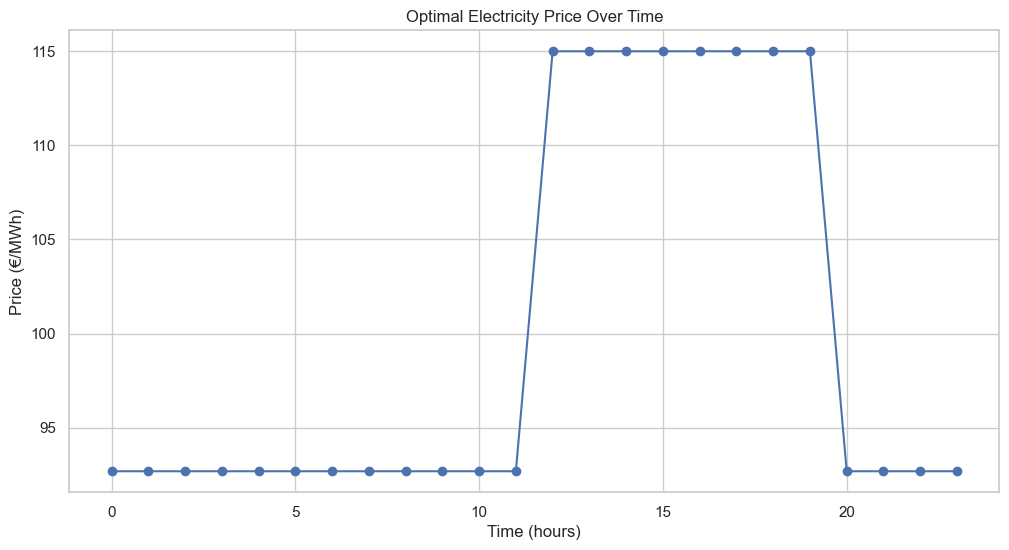

Optimized Cost of Electricity:  1800779
Resulting GHG Emissions:  12474


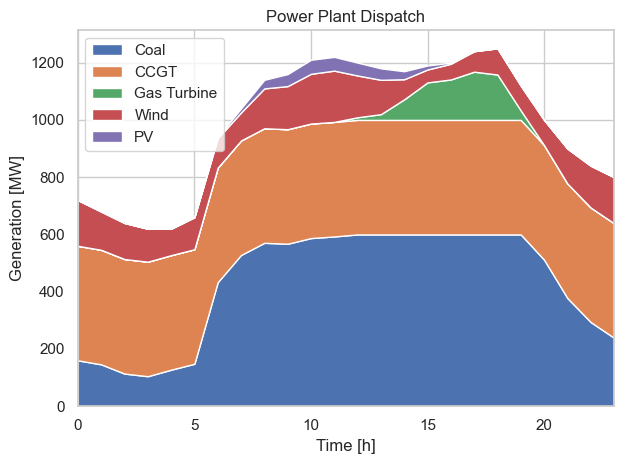

In [17]:
c_CO2=0
min_emissions=10563.40751131
   
# Create Pyomo model
model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)
model.dual = Suffix(direction=Suffix.IMPORT)  # Enable dual information

print(model)

# Specify objective function!

model.obj = Objective(
    expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps) + 
           sum(model.x[n,t] * emissions[n] * c_CO2 for n in thermalPlant for t in timesteps),
    sense = minimize
)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t] - Wind[t] - PV[t]
def emissions_constraint_rule(model, n, t):    
   return sum(model.x[n,t] * emissions[n] for n in thermalPlant) <= min_emissions


model.power_con = Constraint(thermalPlant, timesteps, rule = power_constraint_rule)
model.load_con = Constraint(timesteps, rule = load_constraint_rule)
model.emissions_con = Constraint(thermalPlant, timesteps, rule = emissions_constraint_rule)


opt = SolverFactory('gurobi')
opt_success = opt.solve(model)



# model.display()

# Get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value
    PowerThermal.loc[t, 'Wind'] = Wind[t]
    PowerThermal.loc[t, 'PV'] = PV[t]



# Calculate total generation and shadow prices for each timestep
total_generation = PowerThermal.sum(axis=1)
shadow_prices = {t: model.dual[model.load_con[t]] for t in timesteps}


# Display the results
print("Shadow Prices for each hour (Optimal prices under competition):")
for t in timesteps:
    print(f"Hour {t}: {shadow_prices[t]:.2f} €/MWh")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(timesteps, [shadow_prices[t] for t in timesteps], marker='o', linestyle='-')
plt.title('Optimal Electricity Price Over Time')
plt.xlabel('Time (hours)')
plt.ylabel('Price (€/MWh)')
plt.grid(True)
plt.show()

# Plot

sns.set_theme(style='whitegrid')

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             PowerThermal.to_numpy(dtype = float).transpose(), 
             labels=thermalPlant + ['Wind', 'PV'])
ax.set_title('Power Plant Dispatch')
ax.legend(loc='upper left')
ax.set_ylabel('Generation [MW]')
ax.set_xlabel('Time [h]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

optimized_cost = model.obj()
resulting_emissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)

print("Optimized Cost of Electricity: ", round(optimized_cost))
print("Resulting GHG Emissions: ", round(resulting_emissions))


In [25]:
emissions_shadow_prices = {(n, t): model.dual[model.emissions_con[n, t]] for n in thermalPlant for t in timesteps}
emissions_shadow_prices_values = [emissions_shadow_prices[n, t] for n in thermalPlant for t in timesteps]

print("Shadow Prices for emissions constraint (€/ton CO2):")
for (n, t), price in emissions_shadow_prices.items():
    print(f"{n}, {t}: {price:.2f}")


Shadow Prices for emissions constraint (€/ton CO2):
Coal, 0: 0.00
Coal, 1: 0.00
Coal, 2: 0.00
Coal, 3: 0.00
Coal, 4: 0.00
Coal, 5: 0.00
Coal, 6: 0.00
Coal, 7: 0.00
Coal, 8: 0.00
Coal, 9: 0.00
Coal, 10: 0.00
Coal, 11: 0.00
Coal, 12: 0.00
Coal, 13: 0.00
Coal, 14: 0.00
Coal, 15: 0.00
Coal, 16: 0.00
Coal, 17: 0.00
Coal, 18: 0.00
Coal, 19: 0.00
Coal, 20: 0.00
Coal, 21: 0.00
Coal, 22: 0.00
Coal, 23: 0.00
CCGT, 0: 0.00
CCGT, 1: 0.00
CCGT, 2: 0.00
CCGT, 3: 0.00
CCGT, 4: 0.00
CCGT, 5: 0.00
CCGT, 6: 0.00
CCGT, 7: 0.00
CCGT, 8: 0.00
CCGT, 9: 0.00
CCGT, 10: 0.00
CCGT, 11: 0.00
CCGT, 12: 0.00
CCGT, 13: 0.00
CCGT, 14: 0.00
CCGT, 15: 0.00
CCGT, 16: 0.00
CCGT, 17: 0.00
CCGT, 18: 0.00
CCGT, 19: 0.00
CCGT, 20: 0.00
CCGT, 21: 0.00
CCGT, 22: 0.00
CCGT, 23: 0.00
Gas Turbine, 0: 0.00
Gas Turbine, 1: 0.00
Gas Turbine, 2: 0.00
Gas Turbine, 3: 0.00
Gas Turbine, 4: 0.00
Gas Turbine, 5: 0.00
Gas Turbine, 6: 0.00
Gas Turbine, 7: 0.00
Gas Turbine, 8: 0.00
Gas Turbine, 9: 0.00
Gas Turbine, 10: 0.00
Gas Turbine, 11: